In [1]:
import os
import pandas as pd
import ipdb
from datetime import datetime, time

In [2]:
from index import add_xl_to_csv

In [3]:
%ls data
xl_fn = 'data/weekly-2020-02-10 0925.xlsx'
df = add_xl_to_csv(xl_fn, '2020.csv')
df

weekly-2020-02-10 0925.xlsx


,datetime,library,opening_type,people_in,people_out
0,2020-01-01 00:00:00,Chipping Barnet,closed,0,0
1,2020-01-01 00:00:00,Colindale,closed,0,0
2,2020-01-01 00:00:00,Edgware,closed,0,0
3,2020-01-01 00:00:00,Finchley Church End,closed,0,0
4,2020-01-01 00:00:00,Golders Green,closed,0,0
...,...,...,...,...,...
561,2020-02-09 23:00:00,East Finchley,closed,0,0
564,2020-02-09 23:00:00,Edgware,closed,0,0
567,2020-02-09 23:00:00,Golders Green,closed,0,0
570,2020-02-09 23:00:00,North Finchley,closed,0,0


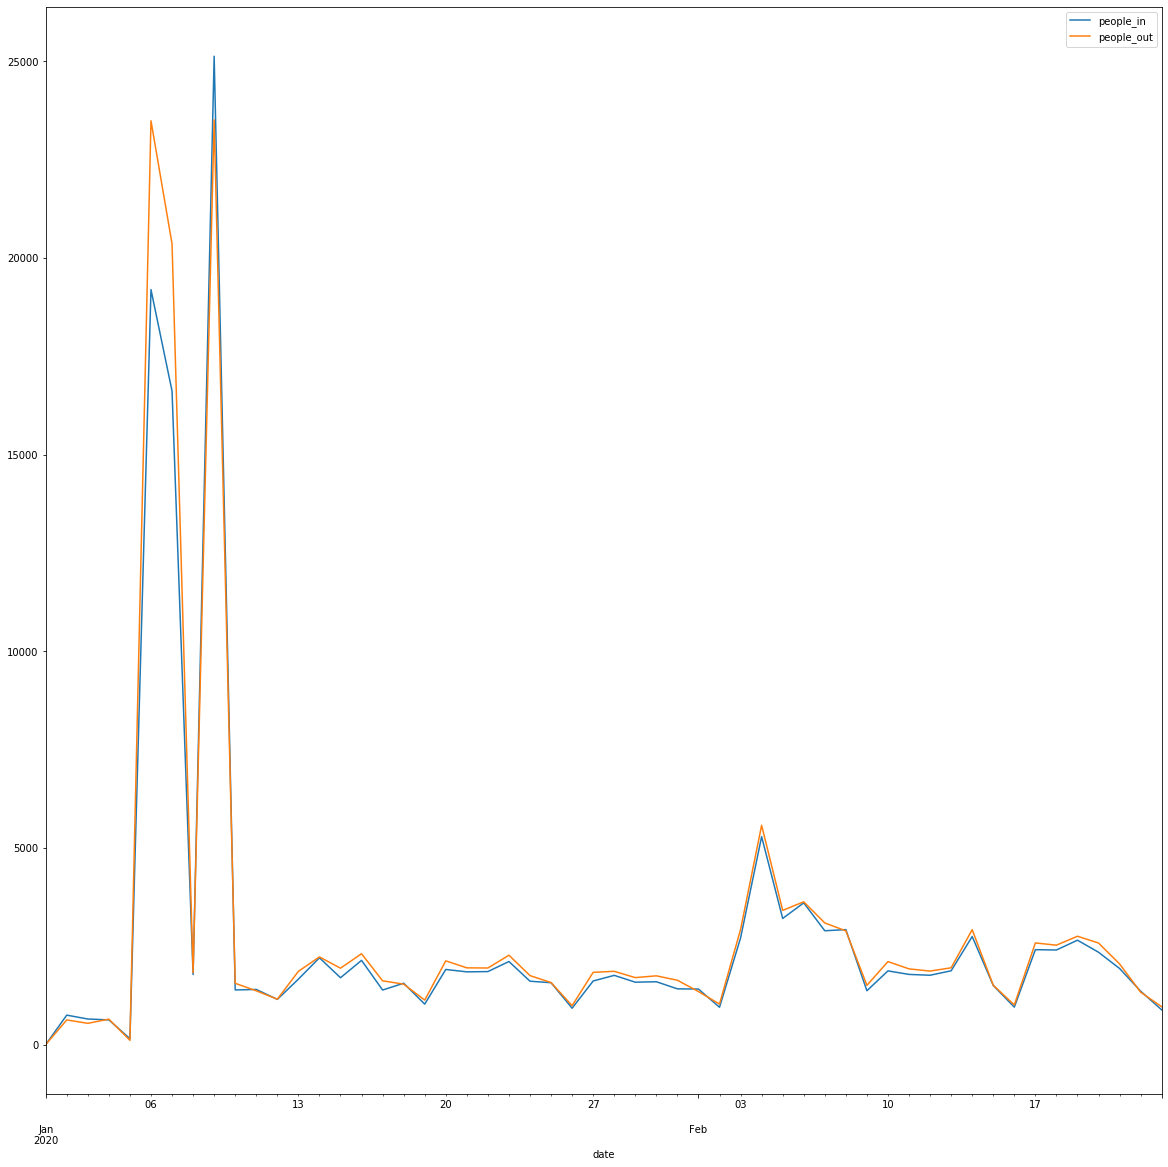

In [10]:
df.assign(date=lambda x: x.datetime.dt.normalize()).groupby('date').sum().plot(figsize=(20,20))